#2_1.Preprocessing and Data augmentation

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

## load data

In [ ]:
from IPython.display import clear_output
!pip install --upgrade kaggle
clear_output()
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 70 bytes


In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:12<00:00, 224MB/s]
100% 2.29G/2.29G [00:12<00:00, 202MB/s]


In [ ]:
!unzip '/content/chest-xray-pneumonia.zip';

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [ ]:
from sklearn.utils import shuffle
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
def extract_images(file_type):
  dir='/content/chest_xray/'+file_type
  unique_labels=os.listdir(dir)
  paths=[]
  labels=[]
  images=[]
  for label in unique_labels:
    for image in os.listdir(dir+'/'+label):
      paths.append(dir+'/'+label+'/'+image)
      labels.append(label)
  paths,labels=shuffle(paths,labels)
  images=[np.array(load_img(path,target_size=(128,128))) for path in paths]
  #binary encoding labels
  mapping={'PNEUMONIA':1,'NORMAL':0}
  for k in range(len(labels)):
    labels[k]=mapping[labels[k]]
  return images, labels

In [ ]:
train_images, train_labels = extract_images('train');
test_images, test_labels = extract_images('test');
val_images, val_labels = extract_images('val');

In [ ]:
images = [*train_images,*test_images,*val_images]
labels =[*train_labels,*test_labels,*val_labels]

In [ ]:
#normalize
images = np.array(images)
labels = np.array(labels)

In [ ]:
images.shape, labels.shape

((5856, 128, 128, 3), (5856,))

## Data Generator

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
train_images,test_images,train_labels,test_labels=train_test_split(images,labels,
                                                                 test_size=0.2)
train_images,val_images,train_labels,val_labels=train_test_split(train_images,
                                                              train_labels,
                                                              test_size=0.25)
pd.Series(train_labels).value_counts()

1    2545
0     968
dtype: int64

Now we have 60% train,20% test,20% validation datas.

We have unbalanced data because we have 2545 PNEUMENIA(1) and 968 NORMAL(0) in our train labels so we should assign class_weights as:

weight of 1 =1,weight of 0=2.6

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#Balance classes
class_weights={0:2.6,1:1}
#data augmentation
datagen=ImageDataGenerator(rotation_range=30,horizontal_flip=True
                           ,shear_range=0.2,width_shift_range=0.2
                         ,height_shift_range=0.2,zoom_range=0.2,rescale=1/255)

train_batches=datagen.flow(train_images,train_labels,batch_size=128)
val_batches=ImageDataGenerator(rescale=1/255).flow(val_images,val_labels,batch_size=128)
test_batches=ImageDataGenerator(rescale=1/255).flow(test_images,test_labels,batch_size=128)     
#from tensorflow.keras.layers import RandomRotation,RandomFlip,RandomZoom,Random                                                           

#2-3.Implementing network

Because in the paper mentioned EficientnetB2 gave the best results I'll use B2 for transfer learning.

In [ ]:
#import efficientnet
from tensorflow.keras.applications import EfficientNetB2
base_model = EfficientNetB2(weights='imagenet',include_top=False
                            ,input_shape=(128,128,3))
#freeze first layer
base_model.layers[0].trainable=False

In [ ]:
#add top_layer structure
from tensorflow.keras.layers import Dense,Dropout,GlobalAveragePooling2D
from tensorflow.keras.activations import relu,sigmoid
from keras.models import Model
x=GlobalAveragePooling2D()(base_model.output)
y=Dense(128,activation=relu)(x)
z=Dropout(0.3)(y)
a=Dense(64,activation=relu)(z)
b=Dropout(0.2)(a)
out=Dense(1,activation=sigmoid)(b)
Top_layers=Model(inputs=base_model.output,outputs=out)
Top_layers.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 4, 4, 1408)]      0         
                                                                 
 global_average_pooling2d_2   (None, 1408)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 128)               180352    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                           

In [ ]:
full_model=Model(inputs=base_model.input,outputs=out)
full_model.summary();

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_4 (Rescaling)        (None, 128, 128, 3)  0           ['input_5[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 128, 128, 3)  7          ['rescaling_4[0][0]']            
 )                                                                                                
                                                                                            

#2-4.Train network,Test network and results

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
from tensorflow.keras.optimizers import Adam,SGD
#from tensorflow.keras.losses import binary_crossentropy
#from sklearn.metrics import f1_score
# from tensorflow_addons.metrics import F1Score
from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.keras.metrics import Accuracy,Precision

full_model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy'
                  ,metrics=['accuracy','Precision',f1_m])
                            # ,F1Score(2)])

In [ ]:
callback=EarlyStopping(
    monitor="val_loss",
    patience=10,
    mode="min",
    baseline=None,
    restore_best_weights=True
)

In [ ]:
hist=full_model.fit(train_batches,validation_data=val_batches,
                              epochs=100,callbacks=[callback],
                              class_weight=class_weights,
                              batch_size=128)

Epoch 1/100
28/28 [==============================] - 85s 717ms/step - loss: 0.5009 - accuracy: 0.8426 - precision: 0.9474 - f1_m: 0.8828 - val_loss: 1.0478 - val_accuracy: 0.7412 - val_precision: 0.7412 - val_f1_m: 0.8476
Epoch 2/100
28/28 [==============================] - 19s 658ms/step - loss: 0.3376 - accuracy: 0.9163 - precision: 0.9695 - f1_m: 0.9400 - val_loss: 1.6594 - val_accuracy: 0.7412 - val_precision: 0.7412 - val_f1_m: 0.8537
Epoch 3/100
28/28 [==============================] - 19s 678ms/step - loss: 0.2538 - accuracy: 0.9362 - precision: 0.9735 - f1_m: 0.9554 - val_loss: 1.1055 - val_accuracy: 0.7412 - val_precision: 0.7412 - val_f1_m: 0.8443
Epoch 4/100
28/28 [==============================] - 19s 668ms/step - loss: 0.2074 - accuracy: 0.9496 - precision: 0.9809 - f1_m: 0.9651 - val_loss: 0.7847 - val_accuracy: 0.7412 - val_precision: 0.7412 - val_f1_m: 0.8371
Epoch 5/100
28/28 [==============================] - 19s 682ms/step - loss: 0.2053 - accuracy: 0.9482 - precisio

In [ ]:
full_model.evaluate(test_batches)

10/10 [==============================] - 1s 104ms/step - loss: 0.6119 - accuracy: 0.7338 - precision: 0.7338 - f1_m: 0.8497


[0.6118728518486023,
 0.7337883710861206,
 0.7337883710861206,
 0.8497123718261719]

Text(0.5, 0, 'epochs')

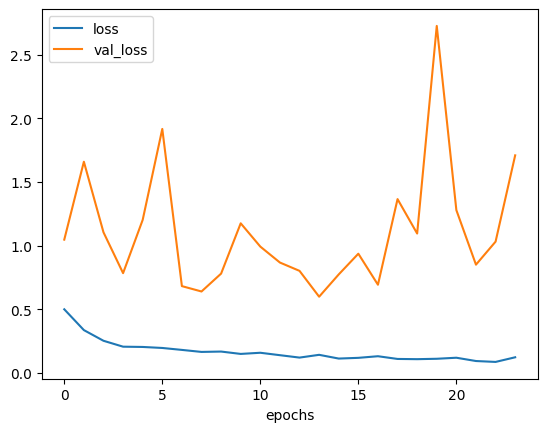

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.xlabel('epochs')

Text(0.5, 0, 'epochs')

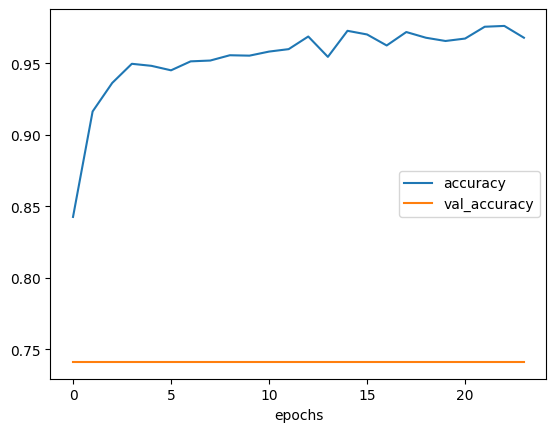

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'])
plt.xlabel('epochs')

37/37 [==============================] - 1s 36ms/step


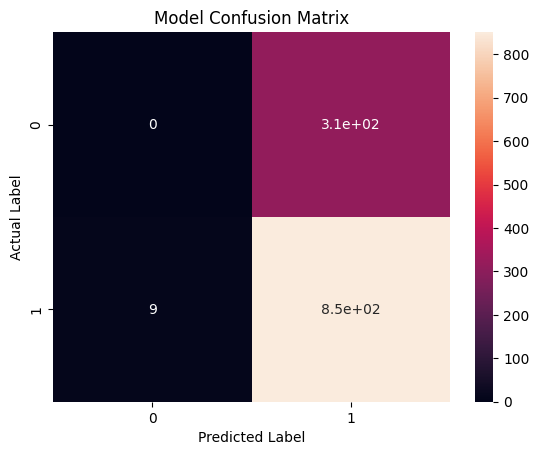

In [ ]:
import numpy as np
y_predict = full_model.predict(test_images)
#We should use round because the model doesnt predict exact one or zero label.
#for example predicts 0.9999 for 1
y_predict=np.round(y_predict)
from sklearn.metrics import confusion_matrix
import seaborn as sns
model_cm=confusion_matrix(test_labels,y_predict)
sns.heatmap(model_cm, annot=True)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Model Confusion Matrix');

In [ ]:
from sklearn.metrics import roc_curve
fpr,tpr,threshold=roc_curve(test_labels,y_predict)


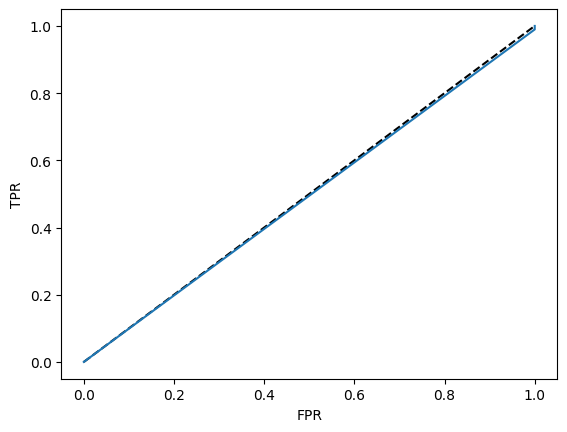

In [ ]:
import matplotlib.pyplot as plt
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr)
plt.xlabel("FPR");
plt.ylabel("TPR");
plt.title('ROC curve')